In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
from utils import (draw_bounding_box_on_image,
                    draw_bounding_boxes_on_image,
                    draw_bounding_boxes_on_image_array)


import tensorflow as tf
import tensorflow_datasets as tfds

print('Tensorflow version:', tf.__version__)

2022-07-27 16:42:47.845811: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-27 16:42:47.845843: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version: 2.9.0


In [3]:
#Helper functions used for visualization.
plt.rc('image', cmap = 'gray')
plt.rc('grid', linewidth = 0)
plt.rc('xtick', top = False, bottom = False, labelsize = 'large')
plt.rc('ytick', left = False, right = False, labelsize = 'large')
plt.rc('axes', facecolor = 'F8F8F8', titlesize = 'large', edgecolor = 'white')
plt.rc('text', color = 'a8151a')
plt.rc('figure', facecolor = 'F0F0F0')
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), 'mpl-data/fonts/ttf')

In [4]:
#Pull a batch from the datasets.
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
    
    #Get one batch from each: 10_000 validation digits, N training digits.
    batch_train_ds = training_dataset.unbatch().batch(N)
    
    #Eager execution: loop through the datasets normally.
    if tf.executing_eagerly():
        for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
            validation_digits = validation_digits.numpy()
            validation_labels = validation_labels.numpy()
            validation_bboxes = validation_bboxes.numpy()
            break
            
        for training_digits, (training_labels, training_bboxes) in batch_train_ds:
            training_digits = training_digits.numpy()
            training_labels = training_labels.numpy()
            training_bboxes = training_bboxes.numpy()
            break
    
    #These were one-hot encoded in the dataset.
    validation_labels = np.argmax(validation_labels, axis = 1)
    training_labels = np.argmax(training_labels, axis = 1)
    
    return (training_digits, training_labels, training_bboxes,
           validation_digits, validation_labels, validation_bboxes)

In [5]:
#Create digits from local fonts for testing.
def create_digits_from_local_fonts(n):
    font_labels = []
    #format 'LA': black in channel 0, alpha in channel 1
    img = PIL.Image.new('LA', (75 * n, 75), color = (0, 255)) 
    font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
    font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
    d = PIL.ImageDraw.Draw(img)
    
    for item in range(n):
        font_labels.append(item % 10)
        d.text((7 + item * 75, 0 if 1 < 10 else -4), str(item % 10), fill = (255, 255), font = font1 if 1 < 10 else font2)
    
    font_digits = np.array(img.getdata(), np.float32)[:, 0] / 255.0 
    font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75 * n]), n, axis = 1), axis = 0), [n, 75 * 75])
    return font_digits, font_labels

In [6]:
#Utility function to display a row of digits with their predictions.
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):
    n = 10
    
    indices = np.random.choice(len(predictions), size = n)
    n_digits = digits[indices]
    n_predictions = predictions[indices]
    n_labels = labels[indices]
    
    n_iou = []
    if len(iou) > 0:
        n_iou = iou[indices]
        
    if (len(pred_bboxes) > 0):
        n_pred_bboxes = pred_bboxes[indices, :]
    
    if (len(bboxes) > 0):
        n_bboxes = bboxes[indices,:]
    
    n_digits = n_digits * 255.0
    n_digits = n_digits.reshape(n, 75, 75)
    fig = plt.figure(figsize = (20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    
    for item in range(10):
        ax = fig.add_subplot(1, 10, item + 1)
        bboxes_to_plot = []
        if (len(pred_bboxes) > item):
            bboxes_to_plot.append(n_pred_bboxes[item])
            
        if (len(bboxes) > item):
            bboxes_to_plot.append(n_bboxes[item])
            
        img_to_draw = draw_bounding_boxes_on_image_array(image = n_digits[item],
                                                         boxes = np.asarray(bboxes_to_plot), color = ['red', 'green'],
                                                        display_str_list = ['true', 'pred'])
        plt.xlabel(n_predictions[item])
        plt.xticks([])
        plt.yticks([])
        
        if n_predictions[item] != n_labels[item]:
            ax.xaxis.label.set_color('red')
            
        plt.imshow(img_to_draw)
        
        if len(iou) > item:
            color = 'black'
            if (n_iou[item][0] < iou_treshold):
                color = 'red'
            ax.text(0.2, -0.3, f'iou: {n_iou[item][0]}', color = color, 
                   transform = ax.transAxes)
            

In [7]:
#Utility function to display training and validation curves.
def plot_metrics(metric_name, title, ylim = 5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color = 'blue', label = metric_name)
    plt.plot(history.history['val_' + metric_name], color = 'green', label = 'val_' + metric_name)

### Select between strategies.
***

Depending on the hardware available, you'll use different distribution strategies.
- If a TPU is available, then you'll be using the TPU strategy. 
- If more than one GPU is available, then you'll use the Mirrored Strategy.
- If one GPU is available or the CPU is available, you'll use the default strategy.

In [9]:
#Detect hardware.
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices('GPU')
    
#Select appropriate distribution strategies.
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu) 
    print(f'Running on TPU {tpu.cluster_spec().as_dict()["worker"]}')

elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print(f'Running on multiple GPUs', [gpu.name for gpu in gpus])
    
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy()
    print(f'Running on GPU{gpus[0].name}')
    
else:
    strategy = tf.distribute.get_strategy()
    print('Running on CPU.')

print('Number of accelerators: ', strategy.num_replicas_in_sync)

Running on CPU.
Number of accelerators:  1


### Parameters.
The global batch size is the batch size per replica(64 in this case) times the number of replicas in the distribution strategy.

In [10]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync

### Load and preprocess the dataset.
***
Define some helper functions that will pre-process your data:
- `read_image_tfds`: randomly overlays the "digit" image on top of a larger canvas.
- `get_training_dataset`: loads data and splits it to get the training set.
- `get_validation_dataset`: loads and splits the data to get the validation set.

In [14]:
def read_image_tfds(image, label):
    '''
    Transforms each image in the dataset by pasting it on
    a 75 * 75 canvas at random locations.
    '''
    xmin = tf.random.uniform((), 0, 48, dtype = tf.int32)
    ymin = tf.random.uniform((), 0, 48, dtype = tf.int32)
    image = tf.reshape(image, (28, 28, 1))
    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
    image = tf.cast(image, tf.float32) / 255.0
    xmin = tf.cast(xmin, tf.float32)
    ymin = tf.cast(ymin, tf.float32)
    
    xmax = (xmin + 28) / 75
    ymax = (ymin + 28) / 75
    xmin = xmin / 75
    ymin = ymin / 75
    return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])

In [17]:
def get_training_dataset():
    '''
    Loads and maps the training split of the dataset
    using the map function. Note that we try to load the GCS 
    version since TPU can only work with datasets on GCS.
    '''
    with strategy.scope():
        dataset = tfds.load('mnist', split = 'train', as_supervised = True, try_gcs = True)
        dataset = (dataset
            .map(read_image_tfds, num_parallel_calls = 16)
            .shuffle(5_000, reshuffle_each_iteration = True)
            .repeat()
            .batch(BATCH_SIZE, drop_remainder = True)
            .prefetch(-1)
        )
    return dataset

In [18]:
def get_validation_dataset():
    '''
    Loads and maps the validation split of the dataset using 
    the `map` function.
    '''
    dataset = tfds.load("mnist", split="test", as_supervised=True, try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)

    dataset = dataset.cache() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

#Instantiate datasets.
with strategy.scope():
    training_dataset = get_training_dataset()
    validation_dataset = get_validation_dataset()

### Visualize the data.

2022-07-27 16:51:34.623417: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


IndexError: index 5600 is out of bounds for axis 0 with size 10

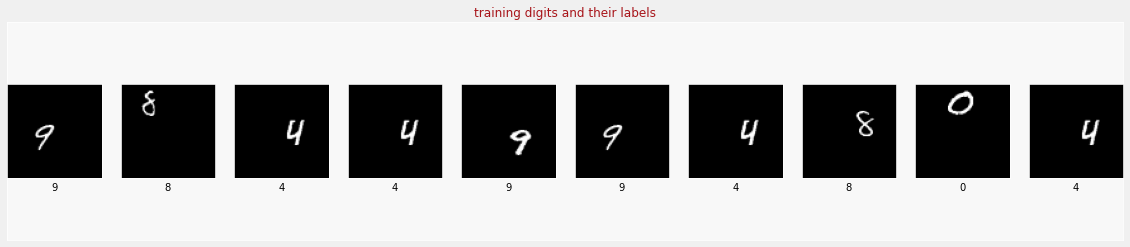

In [19]:
(training_digits, training_labels, training_bboxes, 
validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(training_dataset, validation_dataset, 10)


display_digits_with_boxes(training_digits, training_labels, training_labels, np.array([]),
                          training_bboxes, np.array([]), 'training digits and their labels')

display_digits_with_boxes(validation_digits, validation_labels, validation_labels, np.array([]),
                          training_bboxes, np.array([]), 'validation digits and their labels')

## Define the network.
Here, you'll define your own custom CNN.
- `feature_extractor`: These covolutional layers extract the features of the image.
- `classifier`: This defines the output layer that predicts among 10 categories.
- `bounding_box_regression`: This defines the output layer that predicts 4 numeric values which define the coordinates of the bounding box [xmin, ymin, xmax, ymax]

- `final_model`: This combines the layers for feature extraction, classification and bounding box prediction.

    - Notice that this is another example of a branching model, because the model splits to produce two kinds of output (a category and set of numbers).  
    
- `define_and_compile_model`: choose the optimizer and metrics, then compile the model.

In [20]:
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16, activation = 'relu', kernel_size = 3, input_shape = (75, 75, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(64, kernel_size = 3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    
    return x

In [21]:
def dense_layers(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128, activation = 'relu')(x)
    return x

In [22]:
def classifier(inputs):
    classification_output = tf.keras.layers.Dense(10, activation = 'softmax', name = 'classification')(inputs)
    return classification_output

In [23]:
def bounding_box_regression(inputs):
    '''
    This function defines the regression output from bounding box predictions.
    Note that we have 4 outputs corresponding to [xmin, ymin, xmax, ymax]
    '''
    bounding_box_regression_output = tf.keras.layers.Dense(units = 4, name = 'bounding_box')(inputs)
    return bounding_box_regression_output

In [26]:
def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)
    
    '''
    The model branches here.
    The dense layer's output gets fed into 2 branches:
    classification_output and bounding_box_output.
    '''
    classification_output = classifier(dense_output)
    bounding_box_output = bounding_box_regression(dense_output)
    
    model = tf.keras.Model(inputs = inputs, outputs = [classification_output, bounding_box_output])
    
    return model

In [30]:
def define_and_compile_model(inputs):
    model = final_model(inputs)
    
    model.compile(optimizer = 'adam', 
                 loss = {'classification': 'categorical_crossentropy',
                        'bounding_box': 'mse'
                        },
                 metrics = {'classification': 'accuracy',
                          'bounding_box': 'mse'})
    
    return model

with strategy.scope():
    inputs = tf.keras.Input(shape = (75, 75, 1))
    model = define_and_compile_model(inputs)
    
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 73, 73, 16)   160         ['input_4[0][0]']                
                                                                                                  
 average_pooling2d_9 (AveragePo  (None, 36, 36, 16)  0           ['conv2d_9[0][0]']               
 oling2D)                                                                                         
                                                                                                  
 conv2d_10 (Conv2D)             (None, 34, 34, 32)   4640        ['average_pooling2d_9[0][0]

### Train the model.  
- You can choose the number of epochs depending on the level of performance that you want and the time that you have.
- Each epoch will take just a few seconds if you're using the TPU.

In [31]:
EPOCHS = 10 # 45
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
validation_steps = 1

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

loss, classification_loss, bounding_box_loss, classification_accuracy, bounding_box_mse = model.evaluate(validation_dataset, steps=1)
print("Validation accuracy: ", classification_accuracy)

Epoch 1/10
937/937 [==============================] - ETA: 0s - loss: 0.9813 - classification_loss: 0.9642 - bounding_box_loss: 0.0171 - classification_accuracy: 0.6651 - bounding_box_mse: 0.0171

2022-07-27 17:29:13.199679: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3410560000 exceeds 10% of free system memory.
2022-07-27 17:29:16.384977: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 829440000 exceeds 10% of free system memory.
2022-07-27 17:29:18.606054: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1479680000 exceeds 10% of free system memory.
2022-07-27 17:29:21.665930: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 576000000 exceeds 10% of free system memory.


937/937 [==============================] - 121s 122ms/step - loss: 0.9813 - classification_loss: 0.9642 - bounding_box_loss: 0.0171 - classification_accuracy: 0.6651 - bounding_box_mse: 0.0171 - val_loss: 0.2722 - val_classification_loss: 0.2635 - val_bounding_box_loss: 0.0087 - val_classification_accuracy: 0.9238 - val_bounding_box_mse: 0.0087
Epoch 2/10
488/937 [==============>...............] - ETA: 50s - loss: 0.2823 - classification_loss: 0.2749 - bounding_box_loss: 0.0074 - classification_accuracy: 0.9171 - bounding_box_mse: 0.0074

KeyboardInterrupt: 

NameError: name 'history' is not defined

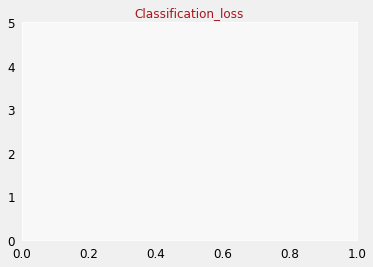

In [32]:
plot_metrics('classification_loss', 'Classification_loss')
plot_metrics('bounding_box_loss', 'Bounding Box Loss')

## Intersection over Union.
Calculate the IOU metric to evaluate the model's performance.

In [33]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, axis = 1)
    
    smoothing_factor = 1e-10
    
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)
    
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)
    
    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0) * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area
    
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)
    
    return iou

In [35]:
##Recognize validation digits
predictions = model.predict(validation_digits, batch_size=64)
predicted_labels = np.argmax(predictions[0], axis=1)

predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, validation_bboxes)

iou_threshold = 0.6

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))


display_digits_with_boxes(validation_digits, predicted_labels, validation_labels, predicted_bboxes, validation_bboxes, iou, "True and Predicted values")

157/157 [==============================] - 6s 37ms/step


TypeError: _split_dispatcher() missing 1 required positional argument: 'indices_or_sections'